In [53]:
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary

In [54]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [55]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [56]:
from pathlib import Path
image_path = Path("D:/MGR/pictures/Data-classification/data")
walk_through_dir(image_path)
image_path_list = list(image_path.glob("*/*/*.jpg"))

There are 4 directories and 0 images in 'D:\MGR\pictures\Data-classification\data'.
There are 9 directories and 0 images in 'D:\MGR\pictures\Data-classification\data\test'.
There are 0 directories and 159 images in 'D:\MGR\pictures\Data-classification\data\test\Flagowy'.
There are 0 directories and 201 images in 'D:\MGR\pictures\Data-classification\data\test\Osemka'.
There are 0 directories and 175 images in 'D:\MGR\pictures\Data-classification\data\test\Prosty'.
There are 0 directories and 175 images in 'D:\MGR\pictures\Data-classification\data\test\Ratowniczy'.
There are 0 directories and 174 images in 'D:\MGR\pictures\Data-classification\data\test\Refowy'.
There are 0 directories and 175 images in 'D:\MGR\pictures\Data-classification\data\test\Rozkowy'.
There are 0 directories and 178 images in 'D:\MGR\pictures\Data-classification\data\test\Szotowy'.
There are 0 directories and 176 images in 'D:\MGR\pictures\Data-classification\data\test\Wyblinka'.
There are 0 directories and 199 im

In [57]:
train_dir = image_path / "train"
valid_dir = image_path / "valid"
test_dir = image_path / "test"
test_diff_dir = image_path / "test-different"

train_dir, valid_dir, test_dir, test_diff_dir

(WindowsPath('D:/MGR/pictures/Data-classification/data/train'),
 WindowsPath('D:/MGR/pictures/Data-classification/data/valid'),
 WindowsPath('D:/MGR/pictures/Data-classification/data/test'),
 WindowsPath('D:/MGR/pictures/Data-classification/data/test-different'))

In [58]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from torchvision.models import regnet_y_800mf, RegNet_Y_800MF_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url


from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

In [7]:
# Get a set of pretrained model weights
weights = torchvision.models.RegNet_Y_800MF_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

RegNet_Y_800MF_Weights.IMAGENET1K_V2

In [8]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    transforms.RandomVerticalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    #transforms.RandomAdjustSharpness(sharpness_factor=0, p=0.5),
    transforms.RandomGrayscale(p = 0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [9]:
# 1. Load data

train_data = datasets.ImageFolder(root=train_dir, transform=augmentation_transforms)
valid_data = datasets.ImageFolder(root=valid_dir, transform=data_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transforms)
test_diff_data = datasets.ImageFolder(root=test_diff_dir, transform=data_transforms)

print(f"Train data:\n{train_data}\nValid data:\n{valid_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 11546
    Root location: D:\MGR\pictures\Data-classification\data\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.5, 0.5))
               RandomGrayscale(p=0.1)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Valid data:
Dataset ImageFolder
    Number of datapoints: 2883
    Root location: D:\MGR\pictures\Data-classification\data\valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           

In [10]:
# Setup batch size and number of workers
BATCH_SIZE = 16

NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

test_diff_dataloader = DataLoader(dataset=test_diff_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS)

train_dataloader, valid_dataloader, test_dataloader, test_diff_dataloader

Creating DataLoader's with batch size 16 and 8 workers.


(<torch.utils.data.dataloader.DataLoader at 0x2613fb385b0>,
 <torch.utils.data.dataloader.DataLoader at 0x2613fb3bdc0>)

In [11]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_dict

{'Flagowy': 0,
 'Osemka': 1,
 'Prosty': 2,
 'Ratowniczy': 3,
 'Refowy': 4,
 'Rozkowy': 5,
 'Szotowy': 6,
 'Wyblinka': 7,
 'Zwykly': 8}

In [12]:
len(train_data), len(valid_data), len(test_data)

(11546, 2883, 1612)

In [13]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = torchvision.models.regnet_y_800mf(weights=weights).to(device)
for param in model_0.parameters():
    param.requires_grad = False

In [14]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for param in model_0.trunk_output.block4.parameters():
    param.requires_grad = True

for param in model_0.trunk_output.block3.parameters():
    param.requires_grad = True

for param in model_0.trunk_output.block2.parameters():
    param.requires_grad = True

# for param in model_0.trunk_output.block1.parameters():
#     param.requires_grad = True
    
for param in model_0.avgpool.parameters():
    param.requires_grad = True
    
for param in model_0.fc.parameters():
    param.requires_grad = True

model_0.fc = torch.nn.Linear(in_features=784,
                             out_features=output_shape, # same number of output units as our number of classes
                             bias=True).to(device)

In [15]:
# Print a summary using torchinfo (uncomment for actual output)
from torchinfo import summary

summary(model=model_0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 9]              --                   Partial
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 784, 7, 7]      --                   Partial
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32

In [16]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from timeit import default_timer as timer

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    best_acc = 0
    model_best = torchvision.models.regnet_y_800mf(weights=weights).to(device)

    model_best.fc = torch.nn.Linear(in_features=784,
                                    out_features=output_shape, # same number of output units as our number of classes
                                    bias=True).to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)


        if test_acc >= best_acc:
            best_model = model
            best_acc = test_acc
            torch.save(obj=best_model.state_dict(), f="RegNetTF-15epok16batch0_0001lr-bezrozmycia-naj.pth")    


        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"valid_loss: {test_loss:.4f} | "
          f"valid_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
            
    # Return the filled results at the end of the epochs
    return results

In [17]:
# Define loss and optimizer
from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.0001)

In [18]:
# Start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

st_time = timer()
# Setup training and save the results
results = train(model=model_0,
               train_dataloader=train_dataloader,
               test_dataloader=valid_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=15,
               device=device)

# End the timer and print out how long it took
e_time = timer()
print(f"[INFO] Total training time: {e_time-st_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9074 | train_acc: 0.6696 | valid_loss: 0.1916 | valid_acc: 0.9472
Epoch: 2 | train_loss: 0.2325 | train_acc: 0.9217 | valid_loss: 0.0963 | valid_acc: 0.9693
Epoch: 3 | train_loss: 0.1121 | train_acc: 0.9638 | valid_loss: 0.0545 | valid_acc: 0.9824
Epoch: 4 | train_loss: 0.0810 | train_acc: 0.9745 | valid_loss: 0.0407 | valid_acc: 0.9876
Epoch: 5 | train_loss: 0.0590 | train_acc: 0.9820 | valid_loss: 0.0444 | valid_acc: 0.9858
Epoch: 6 | train_loss: 0.0414 | train_acc: 0.9861 | valid_loss: 0.0252 | valid_acc: 0.9914
Epoch: 7 | train_loss: 0.0393 | train_acc: 0.9880 | valid_loss: 0.0282 | valid_acc: 0.9927
Epoch: 8 | train_loss: 0.0299 | train_acc: 0.9900 | valid_loss: 0.0436 | valid_acc: 0.9858
Epoch: 9 | train_loss: 0.0261 | train_acc: 0.9918 | valid_loss: 0.0267 | valid_acc: 0.9910
Epoch: 10 | train_loss: 0.0217 | train_acc: 0.9926 | valid_loss: 0.0276 | valid_acc: 0.9910
Epoch: 11 | train_loss: 0.0209 | train_acc: 0.9938 | valid_loss: 0.0327 | valid_acc: 0.99

In [19]:
MODEL_SAVE_PATH = "RegNetTF-15epok16batch0_0001lr-bezrozmycia-ost.pth"

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: RegNetTF-15epok16batch0_0001lr-bezrozmycia-ost.pth


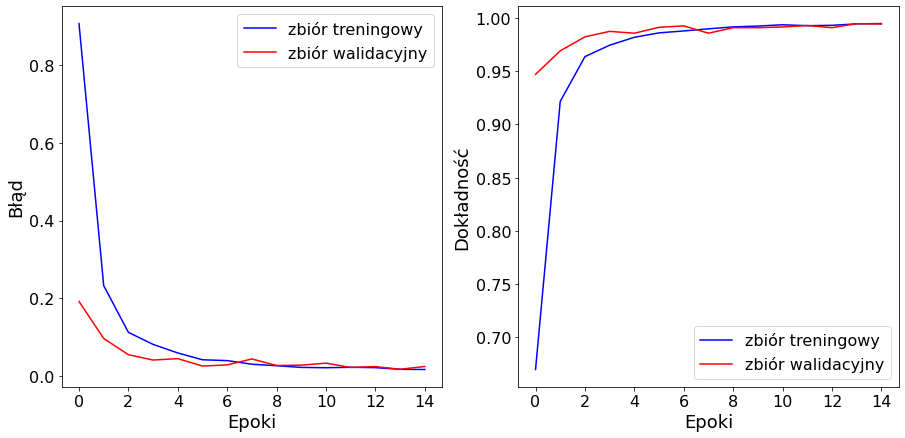

In [20]:
# # Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
# from helper_functions import plot_loss_curves

# # Plot the loss curves of our model
# plot_loss_curves(results)
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="zbiór treningowy", color='blue')
    plt.plot(epochs, test_loss, label="zbiór walidacyjny", color='red')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    # plt.yticks(np.arange(0, 0.31, 0.03))
    # plt.xticks(np.arange(0, 20, 2))
    plt.ylabel("Błąd", fontsize=18)
    plt.xlabel("Epoki", fontsize=18)
    plt.legend(loc='upper right', fontsize=16)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="zbiór treningowy", color='blue')
    plt.plot(epochs, test_accuracy, label="zbiór walidacyjny", color='red')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    # plt.yticks(np.arange(0.92, 1.01, 0.01))
    # plt.xticks(np.arange(0, 20, 2))
    plt.ylabel("Dokładność", fontsize=18)
    plt.xlabel("Epoki", fontsize=18)
    plt.legend(loc='lower right', fontsize=16)

plot_loss_curves(results)

In [21]:
model_0.eval()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

In [22]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

In [23]:
test_acc = check_accuracy(test_dataloader, model_0)
test_diff_acc = check_accuracy(test_diff_dataloader, model_0)

Got 1602 / 1612 with accuracy 99.38
Got 2123 / 2170 with accuracy 97.83


In [24]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/101 [00:23<?, ?it/s]

tensor([0, 0, 0,  ..., 8, 8, 8])

In [25]:
import torchmetrics, mlxtend

In [26]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0,  ..., 8, 8, 8])

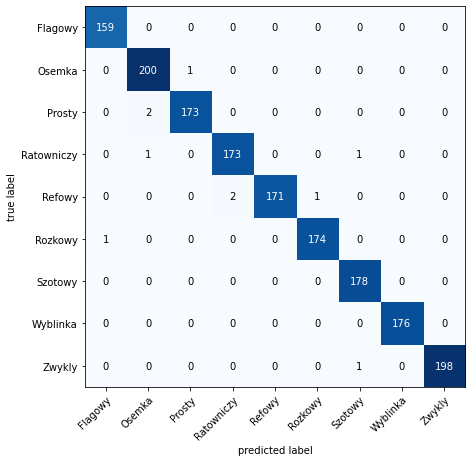

In [27]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    #class_names=['Flagowy', 'Ósemka', 'Prosty', 'Ratowniczy', 'Refowy', 'Rożkowy', 'Szotowy', 'Wyblinka', 'Zwykły'],
    figsize=(10, 7)
)

In [28]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_diff_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_diff_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_diff_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_diff_probs = torch.softmax(test_diff_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_diff_labels = torch.argmax(pred_diff_probs, dim=1)

    # Add the pred labels to test preds list
    test_diff_preds.append(pred_diff_labels)

# Concatenate the test preds and put them on the CPU
test_diff_preds = torch.cat(test_diff_preds).cpu()
test_diff_preds

  0%|          | 0/136 [00:23<?, ?it/s]

tensor([0, 0, 0,  ..., 8, 8, 8])

In [29]:
# Get the truth labels for test dataset
test_diff_truth = torch.cat([y for X, y in test_diff_dataloader])
test_diff_truth

tensor([0, 0, 0,  ..., 8, 8, 8])

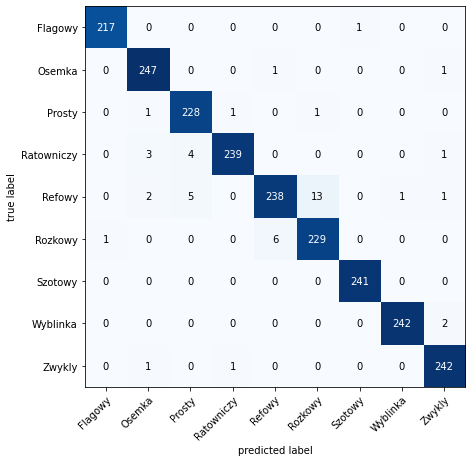

In [30]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=test_diff_preds,
                         target=test_diff_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

In [31]:
model_15 = torchvision.models.regnet_y_800mf(weights=weights).to(device)
model_15.fc = torch.nn.Linear(in_features=784,
                              out_features=output_shape, # same number of output units as our number of classes
                              bias=True).to(device)
model_15.load_state_dict(torch.load("RegNetTF-15epok16batch0_0001lr-bezrozmycia-naj.pth"))
model_15.eval()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

In [32]:
test_acc = check_accuracy(test_dataloader, model_15)
test_diff_acc = check_accuracy(test_diff_dataloader, model_15)

Got 1591 / 1612 with accuracy 98.70
Got 2113 / 2170 with accuracy 97.37


In [33]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_15.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_15(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/101 [00:24<?, ?it/s]

tensor([0, 0, 0,  ..., 8, 8, 8])

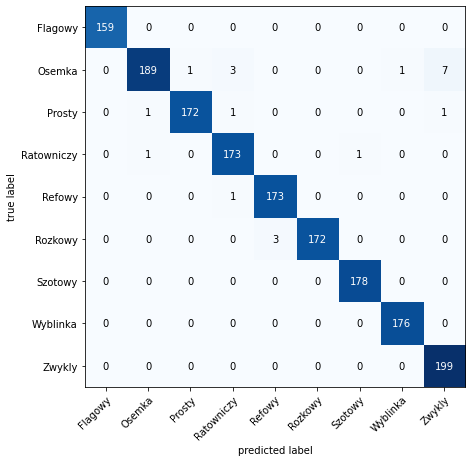

In [34]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    #class_names=['Flagowy', 'Ósemka', 'Prosty', 'Ratowniczy', 'Refowy', 'Rożkowy', 'Szotowy', 'Wyblinka', 'Zwykły'],
    figsize=(10, 7)
)

In [35]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_diff_preds = []
model_15.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_diff_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_diff_logits = model_15(X)

    # Convert the pred logits to pred probs
    pred_diff_probs = torch.softmax(test_diff_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_diff_labels = torch.argmax(pred_diff_probs, dim=1)

    # Add the pred labels to test preds list
    test_diff_preds.append(pred_diff_labels)

# Concatenate the test preds and put them on the CPU
test_diff_preds = torch.cat(test_diff_preds).cpu()
test_diff_preds

  0%|          | 0/136 [00:23<?, ?it/s]

tensor([0, 0, 0,  ..., 8, 8, 8])

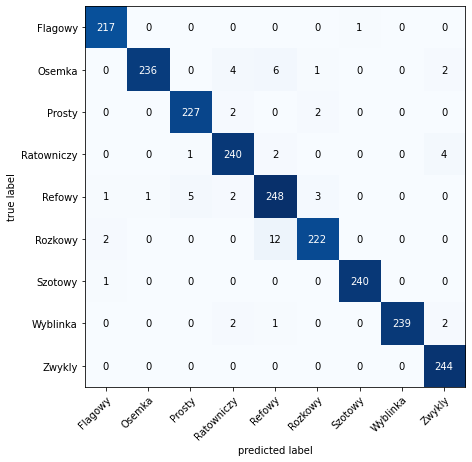

In [36]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=test_diff_preds,
                         target=test_diff_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)